In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import pandas as pd
from pprint import pprint
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [3]:
# Import metadata
meta = pd.read_json(f'{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json').T.reset_index().rename(columns={'index':'sku'})
meta['sleeve_length'] = meta['sleeve_length'].replace('3/4 length', '34 length')
meta.rename(columns = {'sku':'article_id'}, inplace=True)
meta = meta[['article_id', 'brand', 'category', 'garment_type', 'color', 'fabric', 'fit', 'neckline', 'pattern', 'collar', 'length', 'shape', 'sleeve_length']]
cols = ['color', 'fabric', 'fit', 'neckline', 'pattern', 'collar', 'length', 'shape', 'sleeve_length']
meta.rename(columns = {elem:elem.title() for elem in cols}, inplace=True)
cols = [elem.title() for elem in cols]
meta

,article_id,brand,category,garment_type,Color,Fabric,Fit,Neckline,Pattern,Collar,Length,Shape,Sleeve_Length
0,AN621C22S-O11,Anna Field,Shift dress,jersey_dresses,brown,Jersey,Slim Fit,None,Plain,Standing collar,Calf-length,Body-hugging,Short
1,BU321C01G-K11,Buffalo,Jersey dress,jersey_dresses,brown,Jersey,Regular Fit,Low-cut v-neck,Print,None,Knee-length,Fitted,Sleeveless
2,JY121C0TB-A11,JDY,Jersey dress,jersey_dresses,beige,None,Regular Fit,Crew neck,Plain,Standing collar,Knee-length,Flared,Short
3,AN621C1UQ-Q11,Anna Field,Jersey dress,jersey_dresses,brown,Jersey,Slim Fit,Crew neck,Floral,None,Short,Fitted,34 length
4,SHI21C0KH-K11,Sheego,Jersey dress,jersey_dresses,blue,Chiffon,Regular Fit,V-neck,Plain,None,Knee-length,Flared,34 length
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14055,VE121C4BL-Q11,Vero Moda,Maxi dress,maxi_dresses,yellow,None,Regular Fit,Backless,Floral,None,Long,Flared,Sleeveless
14056,TO221C0LB-G11,TOM TAILOR,Maxi dress,maxi_dresses,pink,None,Regular Fit,None,Plain,None,Long,Fitted,Spaghetti straps
14057,UP121C0TZ-Q11,Ulla Popken,Maxi dress,maxi_dresses,black,Jersey,Regular Fit,Square neck,Plain,None,Long,Flared,Extra short
14058,I0621C03C-B11,INFLUENCER,Maxi dress,maxi_dresses,beige,None,Regular Fit,Low-cut v-neck,Plain,None,Long,Flared,Sleeveless


In [4]:
def predict_attribute_values(df: pd.DataFrame, attribute_name: str, seed: int = 123, confidence_threshold: float = 0.8) -> pd.DataFrame:
    """Predict missing attribute values using multiclass classifiers."""
    # Load embeddings
    embeddings = []
    ids = []
    for sample in ['train', 'val']:
        with open(f'{DATA_PATH}/Models/disentangled_representations/zalando_germany/embeddings/vitb14/{sample}.pkl', 'rb') as f:
            data = pickle.load(f)
        embeddings.append(data['embeddings'].numpy())
        ids.extend(data['images_ids'])
    embeddings = np.concatenate(embeddings)
    ids = pd.Series(ids, name='article_id')

    # Split into missing and non-missing collar
    attribute_df = df[df[attribute_name].isna() == False][['article_id', attribute_name]]
    attribute_available = ids.isin(attribute_df.article_id)
    attribute_missing = ~attribute_available

    # Prepare the data
    X = embeddings[attribute_available]
    y = ids[attribute_available].to_frame().merge(attribute_df, how='left')[attribute_name]

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Individual classifiers
    clf_lr = LogisticRegression(random_state=seed, max_iter=5000)
    clf_xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='mlogloss')
    clf_svm = SVC(random_state=seed, probability=True)

    # Combine the models in an ensemble
    clf = VotingClassifier(estimators=[('lr', clf_lr), ('xgb', clf_xgb), ('svm', clf_svm)], voting='soft')
    clf.fit(X_train, y_train)

    # Evaluate the model
    high_confidence = clf.predict_proba(X_test).max(axis=-1) > confidence_threshold
    y_pred = clf.predict(X_test)
    most_frequent_class = np.bincount(y_test).argmax()
    y_pred_ref = np.repeat(most_frequent_class, len(y_test))

    f1 = f1_score(y_test, y_pred, average="macro")
    f1_confident = f1_score(y_test[high_confidence], y_pred[high_confidence], average="macro")
    f1_ref = f1_score(y_test, y_pred_ref, average="macro")

    accuracy = (y_test == y_pred).mean()
    accuracy_confident = (y_test[high_confidence] == y_pred[high_confidence]).mean()
    accuracy_ref = (y_test == y_pred_ref).mean()

    print(f'F1 Score: {f1:.4f} (all obs), {f1_confident:.4f} (high confidence), {f1_ref:.4f} (reference)')
    print(f'Accuracy: {accuracy:.2%} (all obs), {accuracy_confident:.2%} (high confidence), {accuracy_ref:.2%} (reference)')

    # Predict on the articles with missing collar information
    missing_attribute_data = embeddings[attribute_missing]
    missing_attribute_probas = clf.predict_proba(missing_attribute_data)
    missing_attribute_preds = le.inverse_transform(clf.predict(missing_attribute_data))

    # Plot distribution of probabilities
    plt.hist(missing_attribute_probas.max(axis=-1), bins=30)
    plt.axvline(confidence_threshold, color='red', linestyle='dashed')
    plt.title(f'Confidence of predictions for missing {attribute_name.lower()} values')
    plt.show()

    # Convert predictions to dataframe
    missing_attribute_preds_df = pd.DataFrame({
        'article_id': ids[attribute_missing],
        attribute_name:missing_attribute_preds,
    })

    # Filter for confident predictions
    threshold_mask = missing_attribute_probas.max(axis=-1) > confidence_threshold
    missing_attribute_preds_df_confident = missing_attribute_preds_df[threshold_mask]

    # Create mapping
    missing_mapping = missing_attribute_preds_df_confident.set_index('article_id')[attribute_name].to_dict()

    return missing_mapping

In [5]:
for col in cols:
    na = meta[col].isna().sum()
    print(col + ': ' + str(na))

Color: 0
Fabric: 6416
Fit: 115
Neckline: 2359
Pattern: 640
Collar: 11081
Length: 15
Shape: 340
Sleeve_Length: 12


F1 Score: 0.3312 (all obs), 0.3772 (high confidence), 0.0248 (reference)
Accuracy: 53.10% (all obs), 62.40% (high confidence), 26.77% (reference)


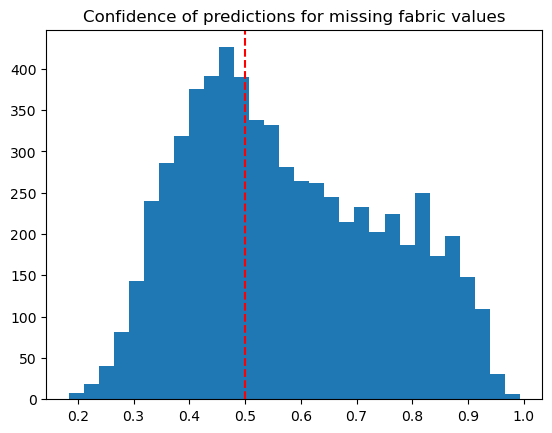

In [6]:
attribute_name = 'Fabric'
missing_mapping = predict_attribute_values(meta, attribute_name, confidence_threshold=0.5)
attribute_mapping = missing_mapping | meta[meta[attribute_name].isna() == False].set_index('article_id')[attribute_name].to_dict()
meta[attribute_name] = meta.article_id.map(attribute_mapping)

F1 Score: 0.2332 (all obs), 0.2654 (high confidence), 0.0421 (reference)
Accuracy: 54.06% (all obs), 80.56% (high confidence), 33.75% (reference)


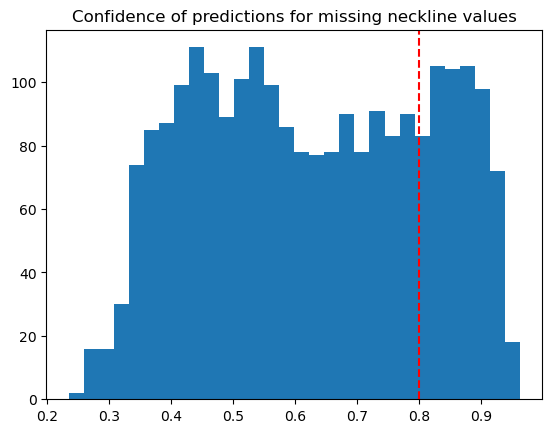

In [7]:
attribute_name = 'Neckline'
missing_mapping = predict_attribute_values(meta, attribute_name)
attribute_mapping = missing_mapping | meta[meta[attribute_name].isna() == False].set_index('article_id')[attribute_name].to_dict()
meta[attribute_name] = meta.article_id.map(attribute_mapping)

F1 Score: 0.2492 (all obs), 0.2968 (high confidence), 0.0421 (reference)
Accuracy: 64.77% (all obs), 81.61% (high confidence), 50.78% (reference)


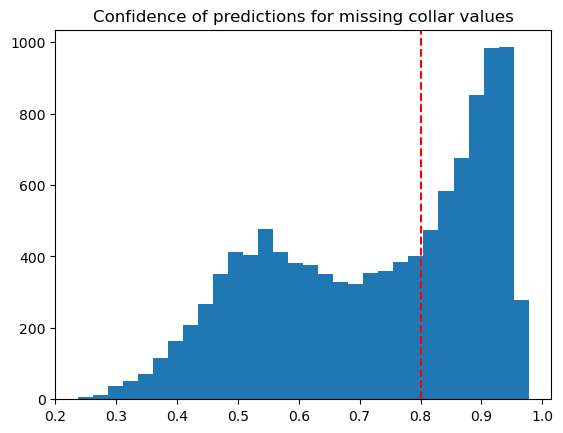

In [8]:
attribute_name = 'Collar'
missing_mapping = predict_attribute_values(meta, attribute_name)
attribute_mapping = missing_mapping | meta[meta[attribute_name].isna() == False].set_index('article_id')[attribute_name].to_dict()
meta[attribute_name] = meta.article_id.map(attribute_mapping)

In [9]:
# Fill remaining missing
meta.fillna('--missing--', inplace=True)

In [10]:
def encode_with_other(s: pd.Series, threshold: int) -> pd.Series:
    cats = s.index.where(s > threshold).dropna().tolist()
    cats = ['Missing', 'Other'] + [cat for cat in cats if cat not in ['--missing--', 'Other']]
    return dict(zip(cats, range(len(cats))))

In [11]:
task_label_mapping = {
    'Color': encode_with_other(meta.Color.value_counts(dropna=False), 0),
    'Fabric': encode_with_other(meta.Fabric.value_counts(dropna=False), 0),
    'Fit': encode_with_other(meta.Fit.value_counts(dropna=False), 0),
    'Neckline': encode_with_other(meta.Neckline.value_counts(dropna=False), 0),
    'Pattern': encode_with_other(meta.Pattern.value_counts(dropna=False), 0),
    'Collar': encode_with_other(meta.Collar.value_counts(dropna=False), 0),
    'Length': encode_with_other(meta.Length.value_counts(dropna=False), 0),
    'Shape': encode_with_other(meta.Shape.value_counts(dropna=False), 0),
    'Sleeve_Length': encode_with_other(meta.Sleeve_Length.value_counts(dropna=False), 0),
}
pprint(task_label_mapping, sort_dicts=False)

{'Color': {'Missing': 0,
           'Other': 1,
           'black': 2,
           'blue': 3,
           'beige': 4,
           'green': 5,
           'grey': 6,
           'brown': 7,
           'pink': 8,
           'white': 9,
           'purple': 10,
           'orange': 11,
           'red': 12,
           'silver': 13,
           'yellow': 14,
           'gold': 15},
 'Fabric': {'Missing': 0,
            'Other': 1,
            'Jersey': 2,
            'Chiffon': 3,
            'Knit': 4,
            'Satin': 5,
            'Rib': 6,
            'Denim': 7,
            'Tulle': 8,
            'Lace': 9,
            'Sweat': 10,
            'Mixed': 11,
            'Mesh': 12,
            'Velvet/velour': 13,
            'Piqué': 14,
            'Crocheted': 15,
            'Faux leather': 16,
            'Cord': 17},
 'Fit': {'Missing': 0,
         'Other': 1,
         'Regular Fit': 2,
         'Slim Fit': 3,
         'Loose Fit': 4,
         'Skinny Fit': 5,
         'Oversized'

### Sample Split

In [12]:
meta.replace('--missing--', 'Missing', inplace=True)

In [13]:
np.random.seed(0)

# Split into train and test set
train_ids = meta.sample(frac=0.7).article_id

# Assign to new column
meta['sample'] = np.where(meta.article_id.isin(train_ids), 'train', 'val')

In [14]:
meta.to_csv(f'{DATA_PATH}/Models/disentangled_representations/zalando_germany/labels.csv', index=False)

In [15]:
for task in task_label_mapping.keys():
    for sample in ['train', 'val']:
        print(f'\033[1m{task} ({sample})\033[0m')
        print(
            meta
            .query('sample == @sample')[task]
            .value_counts(normalize=True)
            .rename_axis(None)
        )
        print()

Color (train)
black     0.234708
blue      0.148141
beige     0.141536
grey      0.084637
green     0.084231
brown     0.074578
pink      0.060658
white     0.039321
orange    0.037086
purple    0.035054
red       0.021540
silver    0.017578
yellow    0.015952
gold      0.004979
Name: proportion, dtype: float64

Color (val)
black     0.243243
blue      0.144381
beige     0.129445
green     0.093883
grey      0.088193
brown     0.070650
pink      0.062352
white     0.041015
purple    0.037221
orange    0.027264
red       0.022997
silver    0.019440
yellow    0.016833
gold      0.003082
Name: proportion, dtype: float64

Fabric (train)
Jersey           0.269356
Missing          0.188173
Chiffon          0.143772
Knit             0.114814
Satin            0.073156
Rib              0.072038
Denim            0.028856
Tulle            0.026113
Lace             0.023572
Sweat            0.017070
Mixed            0.014022
Mesh             0.011685
Velvet/velour    0.006198
Piqué            0.00